In [1]:
#!/global/common/software/lsst/common/miniconda/current/envs/stack/bin/python
# set mode: which class from which to match the hosts
# mode = 'SN Ia'
# mode = 'SN II'
# mode = 'SLSN-I'
# mode = 'SN IIP'
# mode = 'SN IIb'
# mode = 'SN IIn'
# mode = 'SN Ib'
# mode = 'SN Ic'
mode = 'SN Ibc'
plotting = False
full = True
if full:
    tot = 3000000
else:
    tot = 5000
if ' ' in mode:
    modestr = mode.replace(' ','')

from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
import os
import GCRCatalogs
from astropy.io import fits
import pandas as pd
from astropy.cosmology import Planck15 as P15
from astropy import units as u
import matplotlib
import time
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
import numpy.ma as ma

In [2]:
mode = 'SN Ia'

In [3]:
def min_max_normalize(feature, feature_name):
    norm_feature = (feature - np.amin(feature))/(np.amax(feature)-np.amin(feature))
    plt.hist(norm_feature)
    plt.title(feature_name)
    plt.show()
    plt.clf()
    return(norm_feature)

file = '/global/cscratch1/sd/mlokken/sn_hostenv/GHOSTwithImageSizes.csv'
ghost = pd.read_csv(file, memory_map=True, low_memory=True)
print(ghost.columns)
if mode == 'SN II':
    a = ghost['TransientClass']==mode
    b = ghost['TransientClass']=='SN IIP'
    c = ghost['TransientClass']=='SN IIb'
    d = ghost['TransientClass']=='SN IIn'
    ghost = ghost[np.logical_or(np.logical_or(np.logical_or(a,b),c), d)]
elif mode == 'SN Ibc':
    a = ghost['TransientClass'] == 'SN Ib'
    b = ghost['TransientClass'] == 'SN Ic'
    c = ghost['TransientClass'] == 'SLSN-I' # lump in SLSN hosts because there are too few of them for it to be its own hostlib
    ghost = ghost[np.logical_or(np.logical_or(a,b),c)]
else:
    ghost = ghost[ghost['TransientClass']==mode]
ghost.reset_index(inplace=True, drop=True)
print("Number of {:s}: {:d}".format(mode,len(ghost)))
transient_class = ghost['TransientClass']
gMag_G = ghost['gKronMag_SDSS_abs']
gMag_R = ghost['rKronMag_SDSS_abs']
gMag_I = ghost['iKronMag_SDSS_abs']
gMag_Z = ghost['zKronMag_SDSS_abs']
g_rshift = ghost['NED_redshift']
g_rshift2 = ghost['TransientRedshift']
g_ellip  = ghost['r_ellip']
g_gr   = ghost['g-r_SDSS_rest']
g_ri   = ghost['r-i_SDSS_rest']
g_iz   = ghost['i-z_SDSS_rest']

Index(['objID', 'raMean', 'decMean', 'NED_redshift', 'TransientRedshift',
       'gKronMag', 'gApMag', 'gPSFMag', 'rKronMag', 'rApMag', 'rPSFMag',
       'iKronMag', 'iApMag', 'iPSFMag', 'zKronMag', 'zApMag', 'zPSFMag',
       'yKronMag', 'yApMag', 'yPSFMag', 'gKronMagErr', 'gApMagErr',
       'gPSFMagErr', 'rKronMagErr', 'rApMagErr', 'rPSFMagErr', 'iKronMagErr',
       'iApMagErr', 'iPSFMagErr', 'zKronMagErr', 'zApMagErr', 'zPSFMagErr',
       'yKronMagErr', 'yApMagErr', 'yPSFMagErr', 'g-r', 'r-i', 'i-z', 'z-y',
       'g-rErr', 'r-iErr', 'i-zErr', 'z-yErr', 'g_ellip', 'r_ellip', 'i_ellip',
       'z_ellip', 'y_ellip', 'g_elong', 'r_elong', 'i_elong', 'z_elong',
       'y_elong', 'ghalfLightRad', 'rhalfLightRad', 'ihalfLightRad',
       'zhalfLightRad', 'yhalfLightRad', 'gKronMag_SDSS', 'rKronMag_SDSS',
       'iKronMag_SDSS', 'zKronMag_SDSS', 'yKronMag_SDSS', 'g-r_SDSS',
       'r-i_SDSS', 'i-z_SDSS', 'z-y_SDSS', 'TransientClass',
       'gKronMag_SDSS_rest', 'rKronMag_SDSS_rest', 'i

In [19]:
ghost['rRSQ']

0       0.716889
1       0.716889
2       0.521487
3       0.521487
4       0.802561
          ...   
8839    1.020392
8840    0.616777
8841    0.722245
8842    0.539054
8843    0.743036
Name: rRSQ, Length: 8844, dtype: float64

(0.0, 2.0)

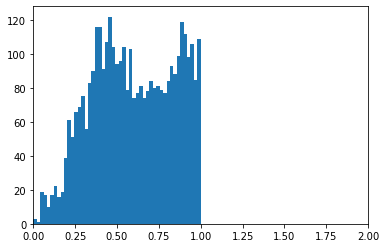

In [17]:
plt.hist(ghost['zR_kpc'], bins=np.linspace(0,1))
plt.xlim([0,2])

In [4]:
# keep track of indices from original file
og_ghost_idx = np.arange(len(ghost))
keydata = np.vstack((gMag_G, gMag_R, gMag_I, gMag_Z, g_gr, g_ri, g_iz, g_ellip, g_rshift, g_rshift2)).T
# first remove all -999s:
keydata[np.logical_or(keydata<-50,keydata>100)] = np.nan
# get rid of redshifts with nan
delete_znans = []
z_nans = 0
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        z_nans += 1
for i in range(len(keydata)):
    if np.isnan(keydata[i,8]):
        # if transient redshift is not nan, replace with transient redshift
        if not np.isnan(keydata[i,9]):
            keydata[i,8] = keydata[i,9]
        else:
            delete_znans.append(i)
    if keydata[i,8] <= 0:
        delete_znans.append(i)
keydata = np.delete(keydata, delete_znans, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_znans)
delete_rows = []
# delete rows with more than one nan
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        nan_counter = 0
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                nan_counter+=1
        if nan_counter > 1:
            delete_rows.append(i)
keydata = np.delete(keydata, delete_rows, axis=0)
og_ghost_idx = np.delete(og_ghost_idx, delete_rows)
# finally for rows with just one nan, replace with the average value
for i in range(len(keydata)):
    if np.isnan(np.sum(keydata[i])):
        for j in range(1, len(keydata[i])):
            if np.isnan(keydata[i,j]):
                keydata[i,j] = np.nanmean(keydata[:,j])

In [5]:
gG = keydata[:,0]
gR = keydata[:,1]
gI = keydata[:,2]
gZ = keydata[:,3]
g_gr = keydata[:,4]
g_ri   = keydata[:,5]
g_iz   = keydata[:,6]
g_ellip = keydata[:,7]
g_rshift = keydata[:,8]

# read in file of CosmoDC2 galaxies, with PZFlow SFR and redshifts, limited to abs r-band magnitude < -15
# and -0.18 < i-z < 0.5
if full:
    cdc2 = pd.read_csv("~/DC2full_pzRedshifts_SFR_39iter.csv", memory_map=True, low_memory=True)
else:
    cdc2 = pd.read_csv("~/DC2_pzRedshifts_SFR_RMag_lt_neg15.csv", memory_map=True, low_memory=True)
cI = cdc2['Mag_true_i_sdss_z0']
cZ = cdc2['Mag_true_z_sdss_z0']
c_iz = cI-cZ
keep = (c_iz < 0.5)&(c_iz>-0.18)
cdc2 = cdc2.loc[keep]
cdc2.reset_index(inplace=True, drop=True)
cG = cdc2['Mag_true_g_sdss_z0']
cR = cdc2['Mag_true_r_sdss_z0']
cI = cI.loc[keep]
cZ = cZ.loc[keep]
c_iz = c_iz.loc[keep]
c_gr = cG-cR
c_ellip = cdc2['morphology/totalEllipticity']
c_rshift = cdc2['PZflowredshift']
c_Rkpc = cdc2['R_kpc']
sim_keyparams= np.vstack((cR, cI, c_gr, c_iz, c_Rkpc, c_rshift)).T
data_keyparams= np.vstack((gR, gI, g_gr, g_iz, g_Rkpc, g_rshift)).T

In [6]:
# normalize for knn
# The purpose of is this is so that the nearest-neighbors algorithm is searching in a multidimensional space
# where typical distances are similar in all dimensions
ghost_cdc2 = np.vstack((data_keyparams, sim_keyparams))
scaler = StandardScaler()
scaler.fit(ghost_cdc2)
keyparams_norm = scaler.transform(ghost_cdc2)
data_keyparams_norm = keyparams_norm[0:len(data_keyparams[:,0]),:]
sim_keyparams_norm  = keyparams_norm[len(data_keyparams[:,0]):,:]
# Weight redshift
div = 20.
data_keyparams_norm[:,5]/=div
sim_keyparams_norm[:,5]/=div
percentage = 1/div*100
print("Redshift weighting: {:.1f} percent".format(percentage))
n_neigh = int(tot/len(data_keyparams_norm))
print("Number of neighbors: ", n_neigh)

sim_full_indices = np.arange(len(sim_keyparams)) # all the indices for the simulation data that's going in
start = time.time()
nn = NearestNeighbors(n_neighbors=n_neigh, algorithm='auto').fit(sim_keyparams_norm)
dist, indices = nn.kneighbors(data_keyparams_norm, return_distance=True)
end = time.time()
print("time:", end-start)

save_array  = []
check_array = []
sim_idx_shape  = indices.shape
simR_reshaped  = (sim_keyparams[:,0][indices.flatten()]).reshape(sim_idx_shape)
simI_reshaped  = (sim_keyparams[:,1][indices.flatten()]).reshape(sim_idx_shape)
simgr_reshaped  = (sim_keyparams[:,2][indices.flatten()]).reshape(sim_idx_shape)
simiz_reshaped  = (sim_keyparams[:,3][indices.flatten()]).reshape(sim_idx_shape)
sime_reshaped  = (sim_keyparams[:,4][indices.flatten()]).reshape(sim_idx_shape)
simrshift_reshaped  = (sim_keyparams[:,5][indices.flatten()]).reshape(sim_idx_shape)

for j in range(len(simR_reshaped)):
    for m in range(simR_reshaped.shape[1]):
        line_to_add = np.array((simR_reshaped[j][m],simI_reshaped[j][m],simgr_reshaped[j][m],simiz_reshaped[j][m], sime_reshaped[j][m],simrshift_reshaped[j][m], og_ghost_idx[j],dist[j][m]))
        check_array.append(line_to_add)
        save_array.append(np.array((indices[j][m],og_ghost_idx[j],dist[j][m]))) # index of CosmoDC2 galaxy from resampled,index of GHOST from original file,distance between matches

Redshift weighting: 5.0 percent
Number of neighbors:  7957
time: 872.1583142280579


In [7]:
save_array = np.asarray(save_array)
check_array = np.asarray(check_array)
#find duplicates
galaxy_ids = cdc2['galaxy_id'].to_numpy()[save_array[:,0].astype(int)]
# quick version. Takes only unique cosmoDC2 galaxies from array. Indices returns the first instance for any duplicate galaxy.
# Not good if you want to track closest nn distance.
unq, idx = np.unique(galaxy_ids, return_index=True)
check_array_uniques = check_array[idx]

save_array_uniques  = save_array[idx]
matched_indices = save_array_uniques[:,0].astype(int)
cdc2_matched = cdc2.iloc[matched_indices]
galaxy_ids = cdc2_matched['galaxy_id']
nn_dict = {'GHOST_objID':ghost['objID'].to_numpy()[save_array_uniques[:,1].astype(int)], 'nn_distance':save_array_uniques[:,2]}
nn_df   = pd.DataFrame(nn_dict)
nn_df.reset_index(inplace=True, drop=True)
cdc2_matched.reset_index(inplace=True, drop=True)
cdc2_matched_nn = pd.concat([cdc2_matched, nn_df], axis=1)
print(cdc2_matched_nn)

if full:
    cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4")
else:
    cosmo = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")

filters=[(lambda x: np.isin(x, galaxy_ids), 'galaxy_id')]
cdc2_true = cosmo.get_quantities(['mag_true_u_lsst', 'mag_true_g_lsst','mag_true_r_lsst',
                'mag_true_i_lsst', 'mag_true_z_lsst',
                 'mag_true_Y_lsst','size_true', 'size_minor_true',
                 'size_disk_true', 'size_minor_disk_true', 'size_bulge_true',
                 'size_minor_bulge_true','galaxy_id', 'sersic_disk', 'sersic_bulge',
                 'position_angle_true', 'ra', 'dec'], filters=filters)

del cosmo 

#add photoz_errs from the other catalog
if full:
    cosmo_pz = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image_with_photozs_v1")
else:
    cosmo_pz = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small_with_photozs_v1")


         morphology/totalSersicIndex  Mag_true_g_sdss_z0  Mag_true_r_sdss_z0  \
0                           1.405222          -17.266201          -17.729319   
1                           1.127685          -17.576609          -18.017338   
2                           3.755993          -20.639326          -21.464787   
3                           2.940032          -18.512570          -19.275759   
4                           2.791443          -19.153217          -19.722776   
...                              ...                 ...                 ...   
1627046                     2.244106          -20.359365          -20.667791   
1627047                     1.000000          -17.386633          -17.134401   
1627048                     1.000000          -15.586905          -15.726022   
1627049                     3.951770          -14.581787          -14.512783   
1627050                     1.000000          -16.362776          -16.134365   

         Mag_true_i_sdss_z0  Mag_true_z

In [ ]:
cdc2_pz = cosmo_pz.get_quantities(['galaxy_id', 'mag_err_u_photoz', 'mag_err_g_photoz', 'mag_err_r_photoz', 'mag_err_i_photoz', 'mag_err_z_photoz', 'mag_err_y_photoz', 'photoz_mask'])

del cosmo_pz

photoz_mask  = cdc2_pz['photoz_mask']
pz_galaxy_id = cdc2_pz['galaxy_id']
pz_magerr_u  = cdc2_pz['mag_err_u_photoz'][photoz_mask]
pz_magerr_g  = cdc2_pz['mag_err_g_photoz'][photoz_mask]
pz_magerr_r  = cdc2_pz['mag_err_r_photoz'][photoz_mask]
pz_magerr_i  = cdc2_pz['mag_err_i_photoz'][photoz_mask]
pz_magerr_z  = cdc2_pz['mag_err_z_photoz'][photoz_mask]
pz_magerr_y  = cdc2_pz['mag_err_y_photoz'][photoz_mask]

cdc2_pz = pd.DataFrame({'galaxy_id':pz_galaxy_id, 'mag_err_u_photoz':pz_magerr_u, 'mag_err_g_photoz':pz_magerr_g, 'mag_err_r_photoz':pz_magerr_r, 'mag_err_i_photoz':pz_magerr_i, 'mag_err_z_photoz':pz_magerr_z, 'mag_err_y_photoz':pz_magerr_y})
cdc2_true = pd.DataFrame(cdc2_true)
cdc2_pz  = pd.DataFrame(cdc2_pz)
cdc2_nbrs = pd.merge(cdc2_matched_nn, cdc2_true, on=['galaxy_id'], how='left')
cdc2_nbrs_pz = pd.merge(cdc2_nbrs, cdc2_pz, on=["galaxy_id"], how='left')

print(cdc2_nbrs_pz)
# save it all
save_dict = {

'galaxy_id':cdc2_nbrs_pz['galaxy_id'], 'ra':cdc2_nbrs_pz['ra'],'dec':cdc2_nbrs_pz['dec'], 'redshift':cdc2_nbrs_pz['PZflowredshift'], 'mag_true_u_lsst':cdc2_other['mag_true_u_lsst'][sorted_dc2_idx], 'mag_err_u_photoz':cdc2_other['mag_err_u_photoz'][sorted_dc2_idx],
    'mag_true_g_lsst':cdc2_other['mag_true_g_lsst'][sorted_dc2_idx], 'mag_err_g_photoz':cdc2_other['mag_err_g_photoz'][sorted_dc2_idx],'mag_true_r_lsst':cdc2_other['mag_true_r_lsst'][sorted_dc2_idx],'mag_err_r_photoz':cdc2_other['mag_err_r_photoz'][sorted_dc2_idx], 'mag_true_i_lsst':cdc2_other['mag_true_i_lsst'][sorted_dc2_idx],'mag_err_i_photoz':cdc2_other['mag_err_i_photoz'][sorted_dc2_idx], 'mag_true_z_lsst':cdc2_other['mag_true_z_lsst'][sorted_dc2_idx],'mag_err_z_photoz':cdc2_other['mag_err_z_photoz'][sorted_dc2_idx], 'mag_true_Y_lsst':cdc2_other['mag_true_Y_lsst'][sorted_dc2_idx],'mag_err_y_photoz':cdc2_other['mag_err_y_photoz'][sorted_dc2_idx],'size_true':cdc2_other['size_true'][sorted_dc2_idx],'size_minor_true':cdc2_other['size_minor_true'][sorted_dc2_idx],'totalSersicIndex':cdc2['morphology/totalSersicIndex'].to_numpy()[matched_indices],'position_angle_true':cdc2_other['position_angle_true'][sorted_dc2_idx], 'totalEllipticity':cdc2['morphology/totalEllipticity'].to_numpy()[matched_indices],'stellar_mass':cdc2['stellar_mass'].to_numpy()[matched_indices], 'SFRtot':cdc2['PZflowSFRtot'].to_numpy()[matched_indices],'Mag_true_g_sdss_z0':cdc2['Mag_true_g_sdss_z0'].to_numpy()[matched_indices],'GHOST_objID':ghost['objID'][save_array_uniques_neworder[:,1]], 'nn_distance':save_array_uniques_neworder[:,2]}

save_df = pd.DataFrame(save_dict)
save_df.to_csv('~/cdc2_matched_ghost_{:s}_unq_zwgt_5pct_k{:d}.csv'.format(modestr, n_neigh), index=False)

In [ ]:
if plotting:
    if not os.path.exists('../plots/{:s}'.format(modestr)):
        os.mkdir('../plots/{:s}'.format(modestr))
    sns.set_context("poster")
    fig, ax = plt.subplots(nrows=2,ncols=1, figsize=[10,10], sharex=True)
    ax[0].hist(ghost['TransientRedshift'],bins=40, alpha=0.5, color='blue', label='GHOST, {:d} total'.format(len(data_keyparams)))
    ax[1].hist(cdc2['PZflowredshift'][save_array_uniques[:,0]],bins=40,alpha=0.5, color='orange', label='CosmoDC2, {:d} total'.format(len(save_array_uniques)))
    plt.xlabel("redshift")
    plt.legend()
    ax[0].set_ylabel("Number of galaxies")
    ax[1].set_ylabel("Number of galaxies")
    ax[1].ticklabel_format(axis='y', style='sci')
    ax[0].legend()
    plt.savefig("../plots/{0}/cdc2_ghost_{0}_k10_lowz_weighting_matches_unq_histogram.png".format(modestr))

    # check all properties against each other for CosmoDC2
    labels=['R', 'I', 'g-r', 'i-z', 'ellipticity', 'redshift']
    lims =[[-25,-14.5],[-25,-14.5],[-0.3,1.2],[-0.2,0.5],[0,0.4],[0,1]]
    for i in range(6):
        for j in range(6):
            if i!=j:
                fig,ax = plt.subplots(nrows=2,ncols=1,figsize=[7,10],sharex=True)
                im2=ax[1].scatter(data_keyparams[:,j],data_keyparams[:,i],c=dist[:,0], cmap='plasma_r', alpha=0.5, s=1, vmin=0, vmax=3)
                im1=ax[0].scatter(check_array_uniques[:,j],check_array_uniques[:,i],c=check_array_uniques[:,7], cmap='plasma_r', alpha=0.2, s=1, vmin=0, vmax=3)
                ax[1].set_xlabel(labels[j])
                ax[0].set_ylabel(labels[i])
                ax[1].set_ylabel(labels[i])
                ax[0].set_title("CDC2 matched gals")
                ax[1].set_title("GHOST")
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
                cbar = fig.colorbar(im1, cax=cbar_ax)
                cbar.set_label("distance")
                ax[0].set_xlim(lims[j])
                ax[1].set_xlim(lims[j])
                ax[1].set_ylim(lims[i])
                ax[0].set_ylim(lims[i])
                plt.savefig("../plots/{:s}/ghost_cdc2_k10_lowz_weighting_unq_{:s}_vs_{:s}_{:s}.png".format(modestr,labels[i],labels[j],modestr), bbox_inches='tight')
                plt.clf()